In [25]:
%%capture
%pip install transformers datasets scikit-learn torch
%pip install seaborn
%pip install emoji
%pip install imbalanced-learn
%pip install xgboost
%pip install lightgbm


In [26]:
import pandas as pd
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
import re, emoji
from pythainlp.tokenize import word_tokenize, word_detokenize
from pythainlp.corpus import thai_words
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

In [27]:
df = pd.read_csv(r"C:\Users\User\Desktop\mg code\Maximus Work Code\community-clarity\BE\analyze_model\LabeledData.csv", encoding='utf-8-sig')
df = df.drop_duplicates(subset='text', keep='first').drop(columns=['product'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 812 entries, 0 to 826
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   text                 812 non-null    object
 1   sentimentType        812 non-null    object
 2   commentCategoryName  812 non-null    object
dtypes: object(3)
memory usage: 25.4+ KB


In [28]:
VOCAB = set(thai_words())

def clean_tokenize(text):
    text = emoji.replace_emoji(text, '').replace('\n', ' ').replace('\r', ' ') #ลบ emoji และการขึ้นบรรทัดใหม่
    text = re.sub(r'(.)\1{3,}', r'\1\1', text)  # ตัดอักษรซ้ำเกิน 2 ตัว
    text = re.sub(r'[^\u0E00-\u0E7Fa-zA-Z0-9\s:]', '', text)  # ลบอักขระพิเศษ
    seen = set()
    text = " ".join([w for w in text.split() if not (w in seen or seen.add(w))])  # ลบกลุ่มคำซ้ำในคอมเมนต์
    tokens = word_tokenize(text, engine="newmm", keep_whitespace=True) #tokenize
    return [w for w in tokens if w in VOCAB or w.isnumeric()] #กรองคำ

def safe_clean(text):
    try:
        # ตรวจสอบว่าเป็นสตริงและทำความสะอาด
        if isinstance(text, str):
            return clean_tokenize(text)
        else:
            return None  # กรณีที่ไม่ใช่สตริง
    except Exception as e:
        print(f"Error processing row: {e}")  # สามารถแสดงข้อผิดพลาดได้
        return None  # ข้ามไปทำงานต่อ

In [29]:
df["text"] = df["text"].apply(safe_clean)
df = df[df["text"].notnull()]
df

,text,sentimentType,commentCategoryName
0,"[สินค้า, ดี, มี, คุณภาพ, เข้ารูป, ไม่, โค, ล่ง...",pos,product
1,"[จัดส่ง, รวดเร็ว]",pos,delivery
2,"[จัดส่ง, ค่อนข้าง, ช้า]",neg,delivery
3,"[บริการ, ดีมาก, ตอบ, แชท, ค่อนข้าง, ไว]",pos,service
4,"[ทรง, สวย, พอใช้ได้, เหมาะกับ, ใส่, เล่น, อยู่...",neu,product
...,...,...,...
822,"[ความ, ง่าย, ใน, การ, ใช้, ชอบ]",pos,product
823,"[ความทนทาน, รอ, ดู, ความ, ง่าย, ใน, การ, ใช้, ...",neu,product
824,"[ทำความสะอาด, พื้นผิว, ใด, ได้, อย่าง, ง่ายดาย...",neu,product
825,"[เครื่องมือ, ทำความสะอาด, อเนกประสงค์, ขจัด, ส...",neu,product


In [30]:
le = LabelEncoder()
df['sentimentType'] = le.fit_transform(df['sentimentType']) # แปลง labels จาก 'neg', 'neu', 'pos' ให้เป็นตัวเลข

X = df[['text']]
y = df['sentimentType']
cvec = CountVectorizer(analyzer=lambda x:x)
X_vec = cvec.fit_transform(X['text'])

In [31]:
# Cross-validation setup
skf = StratifiedKFold(n_splits=100, shuffle=True, random_state=42)

Logistic Regression classification report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       294
           1       0.43      0.53      0.47       117
           2       0.88      0.82      0.85       401

    accuracy                           0.77       812
   macro avg       0.70      0.72      0.71       812
weighted avg       0.79      0.77      0.78       812



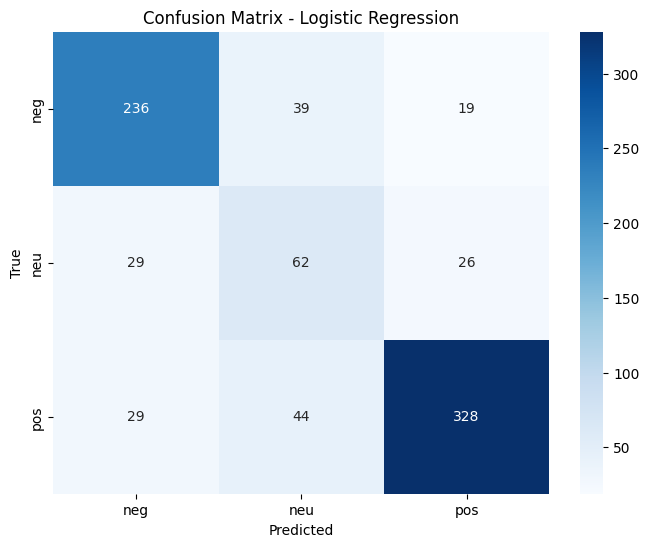

In [32]:
# Logistic Regression Model
log_reg_model = LogisticRegression(max_iter=1000)

# Lists to collect predictions and true labels
all_y_true = []
all_y_pred = []

# Cross-validation loop
for train_index, val_index in skf.split(X_vec, y):
    X_train, X_val = X_vec[train_index], X_vec[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # SMOTE for handling class imbalance
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Train Logistic Regression
    log_reg_model.fit(X_train_res, y_train_res)

    # Predict
    y_pred = log_reg_model.predict(X_val)

    # Append true labels and predictions
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)

# After the loop, print classification report
print("Logistic Regression classification report:")
print(classification_report(all_y_true, all_y_pred))

# Generate confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

Random Forest classification report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       294
           1       0.62      0.40      0.49       117
           2       0.86      0.88      0.87       401

    accuracy                           0.80       812
   macro avg       0.75      0.71      0.72       812
weighted avg       0.80      0.80      0.80       812



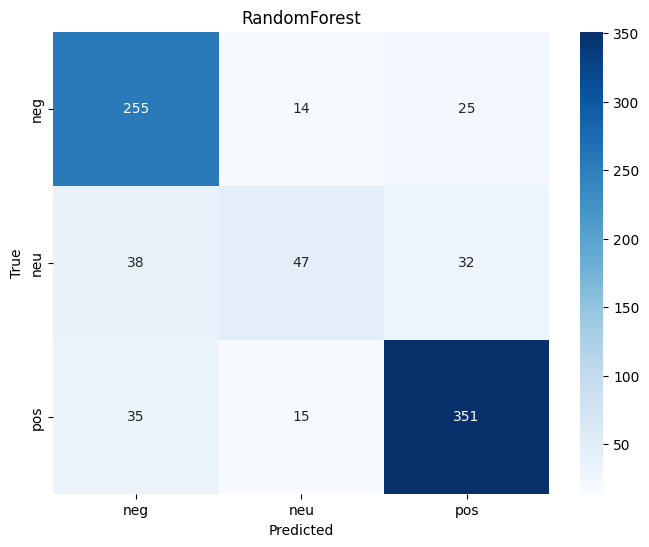

In [33]:
# Random Forest Model
rf_model = RandomForestClassifier()

# Cross-validation setup
all_y_true = []
all_y_pred = []

for train_index, val_index in skf.split(X_vec, y):
    X_train, X_val = X_vec[train_index], X_vec[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # SMOTE for handling class imbalance
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Train Random Forest
    rf_model.fit(X_train_res, y_train_res)

    # Predict
    y_pred = rf_model.predict(X_val)

    # Append true labels and predictions
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)

# After the loop, print classification report
print("Random Forest classification report:")
print(classification_report(all_y_true, all_y_pred))

# Generate confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('RandomForest')
plt.show()


SVM classification report:
              precision    recall  f1-score   support

           0       0.74      0.84      0.79       294
           1       0.48      0.43      0.45       117
           2       0.88      0.83      0.85       401

    accuracy                           0.77       812
   macro avg       0.70      0.70      0.70       812
weighted avg       0.77      0.77      0.77       812



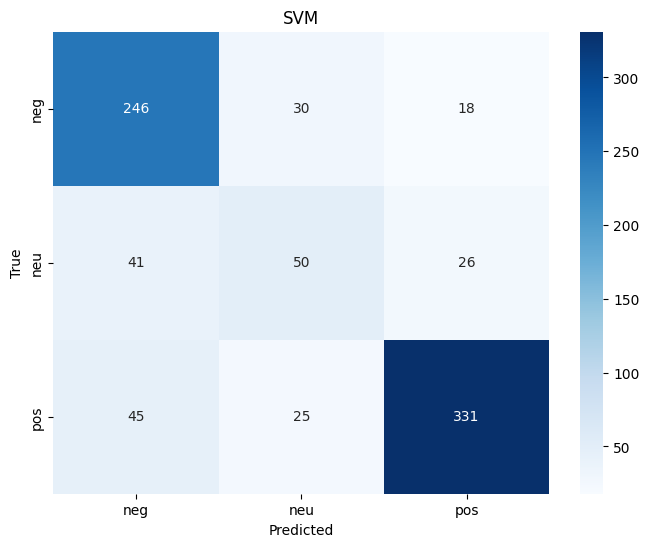

In [34]:
# SVM Model
svm_model = SVC()

# Cross-validation setup
all_y_true = []
all_y_pred = []

for train_index, val_index in skf.split(X_vec, y):
    X_train, X_val = X_vec[train_index], X_vec[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # SMOTE for handling class imbalance
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Train SVM
    svm_model.fit(X_train_res, y_train_res)

    # Predict
    y_pred = svm_model.predict(X_val)

    # Append true labels and predictions
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)

# After the loop, print classification report
print("SVM classification report:")
print(classification_report(all_y_true, all_y_pred))

# Generate confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM')
plt.show()


Naive Bayes classification report:
              precision    recall  f1-score   support

           0       0.71      0.81      0.76       294
           1       0.34      0.26      0.30       117
           2       0.86      0.83      0.85       401

    accuracy                           0.74       812
   macro avg       0.64      0.63      0.63       812
weighted avg       0.73      0.74      0.74       812



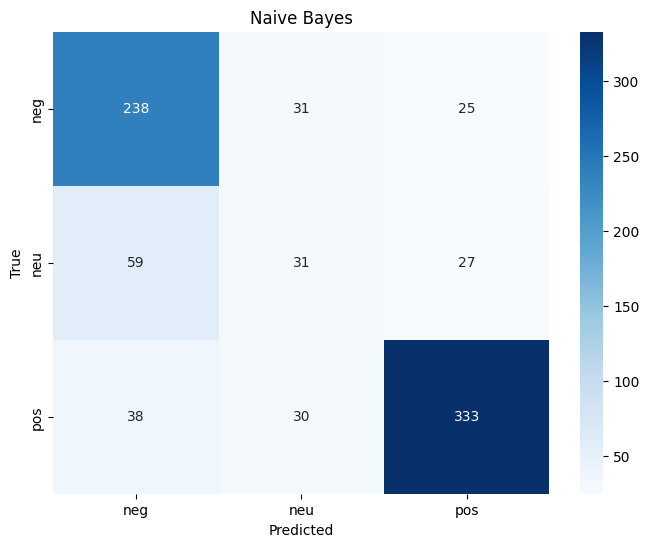

In [35]:
# Naive Bayes Model
nb_model = MultinomialNB()

# Cross-validation setup
all_y_true = []
all_y_pred = []

for train_index, val_index in skf.split(X_vec, y):
    X_train, X_val = X_vec[train_index], X_vec[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # SMOTE for handling class imbalance
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Train Naive Bayes
    nb_model.fit(X_train_res, y_train_res)

    # Predict
    y_pred = nb_model.predict(X_val)

    # Append true labels and predictions
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)

# After the loop, print classification report
print("Naive Bayes classification report:")
print(classification_report(all_y_true, all_y_pred))

# Generate confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Naive Bayes')
plt.show()


XGBoost classification report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       294
           1       0.48      0.44      0.46       117
           2       0.87      0.88      0.87       401

    accuracy                           0.78       812
   macro avg       0.71      0.70      0.71       812
weighted avg       0.78      0.78      0.78       812



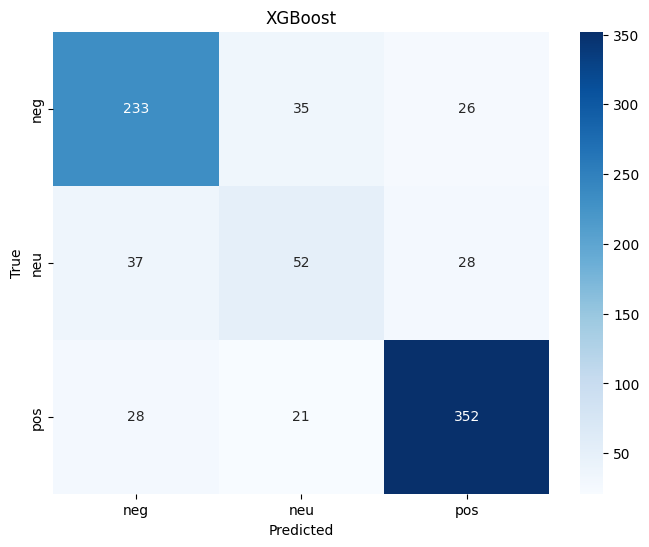

In [36]:
# XGBoost Model
xgb_model = XGBClassifier(eval_metric='mlogloss')

# Cross-validation setup
all_y_true = []
all_y_pred = []

for train_index, val_index in skf.split(X_vec, y):
    X_train, X_val = X_vec[train_index], X_vec[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # SMOTE for handling class imbalance
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Train XGBoost
    xgb_model.fit(X_train_res, y_train_res)

    # Predict
    y_pred = xgb_model.predict(X_val)

    # Append true labels and predictions
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)

# After the loop, print classification report
print("XGBoost classification report:")
print(classification_report(all_y_true, all_y_pred))

# Generate confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('XGBoost')
plt.show()


In [37]:
# ข้อความที่ต้องการทำนาย
my_text = 'กล่องยับไม่มีกันกระแทก'

# ทำ preprocessing เช่นเดียวกับข้อมูล train
my_tokens = clean_tokenize(my_text)

# แปลงเป็น Bag of Words (หรือ TF-IDF ถ้าใช้ TF-IDF ในตอน train)
my_bow = cvec.transform(pd.Series([my_tokens]))

# ใช้โมเดล XGBoost ที่ train แล้วทำนาย
my_predictions = xgb_model.predict(my_bow)

# แปลง label กลับเป็นชื่อ class (ถ้าคุณใช้ LabelEncoder ตอนแรก)
predicted_label = le.inverse_transform(my_predictions)

print(predicted_label)

['neg']


In [38]:
le_category = LabelEncoder()
df['commentCategoryName'] = le_category.fit_transform(df['commentCategoryName'])

A = df[['text']] 
B = df['commentCategoryName'] 

# แปลงข้อความเป็นเวกเตอร์
cvec_category = CountVectorizer(analyzer=lambda x: x) 
X_vec_category = cvec_category.fit_transform(A['text'])

skf_category = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

Logistic Regression classification report for commentCategoryName:
              precision    recall  f1-score   support

           0       0.61      0.81      0.70        80
           1       0.57      0.73      0.64        55
           2       0.96      0.86      0.91       608
           3       0.45      0.59      0.51        69

    accuracy                           0.82       812
   macro avg       0.65      0.75      0.69       812
weighted avg       0.86      0.82      0.83       812



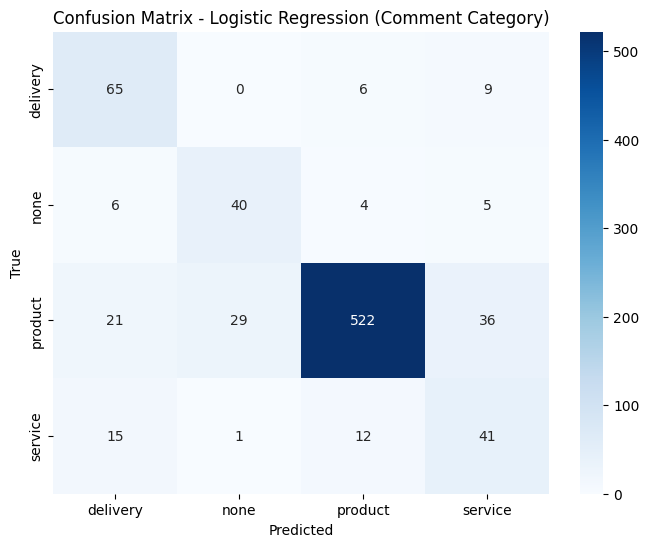

In [39]:
# Lists to collect predictions and true labels
all_y_true_category = []
all_y_pred_category = []

# Cross-validation loop
for train_index, val_index in skf_category.split(X_vec_category, B):
    X_train_category, X_val_category = X_vec_category[train_index], X_vec_category[val_index]
    y_train_category, y_val_category = B.iloc[train_index], B.iloc[val_index]

    # SMOTE for handling class imbalance
    smote = SMOTE(random_state=42)
    X_train_res_category, y_train_res_category = smote.fit_resample(X_train_category, y_train_category)

    # Train Logistic Regression
    log_reg_model.fit(X_train_res_category, y_train_res_category)

    # Predict
    y_pred_category = log_reg_model.predict(X_val_category)

    # Append true labels and predictions
    all_y_true_category.extend(y_val_category)
    all_y_pred_category.extend(y_pred_category)

# After the loop, print classification report
print("Logistic Regression classification report for commentCategoryName:")
print(classification_report(all_y_true_category, all_y_pred_category))

# Generate confusion matrix
cm_category = confusion_matrix(all_y_true_category, all_y_pred_category)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_category, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_category.classes_,
            yticklabels=le_category.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression (Comment Category)')
plt.show()

Random Forest classification report for commentCategoryName:
              precision    recall  f1-score   support

           0       0.59      0.80      0.68        80
           1       0.78      0.64      0.70        55
           2       0.94      0.87      0.90       608
           3       0.39      0.52      0.44        69

    accuracy                           0.82       812
   macro avg       0.67      0.71      0.68       812
weighted avg       0.85      0.82      0.83       812



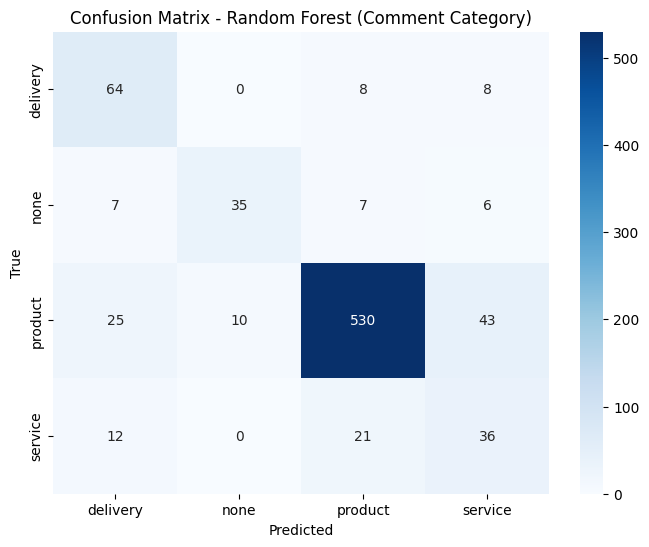

In [40]:
# Random Forest Model
rf_model_category = RandomForestClassifier()

# Lists to collect predictions and true labels
all_y_true_category = []
all_y_pred_category = []

# Cross-validation loop
for train_index, val_index in skf_category.split(X_vec_category, B):
    X_train_category, X_val_category = X_vec_category[train_index], X_vec_category[val_index]
    y_train_category, y_val_category = B.iloc[train_index], B.iloc[val_index]

    # SMOTE for handling class imbalance
    smote = SMOTE(random_state=42)
    X_train_res_category, y_train_res_category = smote.fit_resample(X_train_category, y_train_category)

    # Train Random Forest
    rf_model_category.fit(X_train_res_category, y_train_res_category)

    # Predict
    y_pred_category = rf_model_category.predict(X_val_category)

    # Append true labels and predictions
    all_y_true_category.extend(y_val_category)
    all_y_pred_category.extend(y_pred_category)

# After the loop, print classification report
print("Random Forest classification report for commentCategoryName:")
print(classification_report(all_y_true_category, all_y_pred_category))

# Generate confusion matrix
cm_category = confusion_matrix(all_y_true_category, all_y_pred_category)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_category, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_category.classes_, yticklabels=le_category.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest (Comment Category)')
plt.show()

SVM classification report for commentCategoryName:
              precision    recall  f1-score   support

           0       0.67      0.62      0.65        80
           1       0.72      0.60      0.65        55
           2       0.88      0.93      0.90       608
           3       0.43      0.29      0.35        69

    accuracy                           0.82       812
   macro avg       0.67      0.61      0.64       812
weighted avg       0.81      0.82      0.81       812



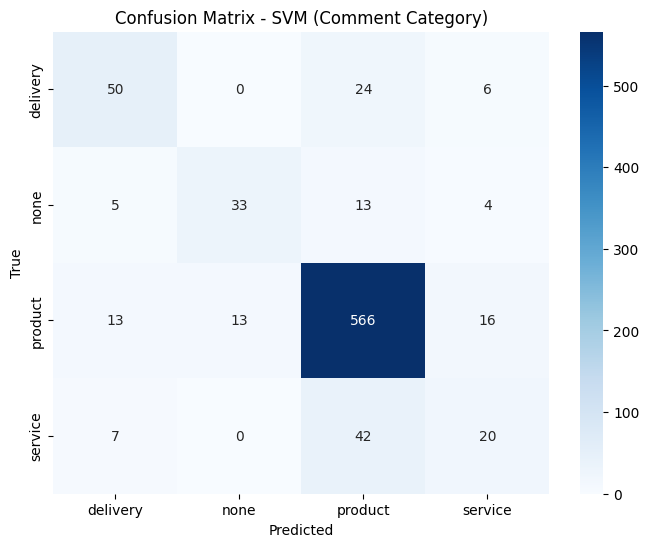

In [41]:
# SVM Model for commentCategoryName
svm_model_category = SVC()

# Lists to collect predictions and true labels
all_y_true_category = []
all_y_pred_category = []

# Cross-validation loop
for train_index, val_index in skf_category.split(X_vec_category, B):
    X_train_category, X_val_category = X_vec_category[train_index], X_vec_category[val_index]
    y_train_category, y_val_category = B.iloc[train_index], B.iloc[val_index]

    # SMOTE for handling class imbalance
    smote = SMOTE(random_state=42)
    X_train_res_category, y_train_res_category = smote.fit_resample(X_train_category, y_train_category)

    # Train SVM
    svm_model_category.fit(X_train_res_category, y_train_res_category)

    # Predict
    y_pred_category = svm_model_category.predict(X_val_category)

    # Append true labels and predictions
    all_y_true_category.extend(y_val_category)
    all_y_pred_category.extend(y_pred_category)

# After the loop, print classification report
print("SVM classification report for commentCategoryName:")
print(classification_report(all_y_true_category, all_y_pred_category))

# Generate confusion matrix
cm_category = confusion_matrix(all_y_true_category, all_y_pred_category)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_category, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_category.classes_, yticklabels=le_category.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM (Comment Category)')
plt.show()

Naive Bayes classification report for commentCategoryName:
              precision    recall  f1-score   support

           0       0.54      0.84      0.66        80
           1       0.48      0.27      0.35        55
           2       0.96      0.87      0.91       608
           3       0.44      0.70      0.54        69

    accuracy                           0.81       812
   macro avg       0.61      0.67      0.61       812
weighted avg       0.84      0.81      0.82       812



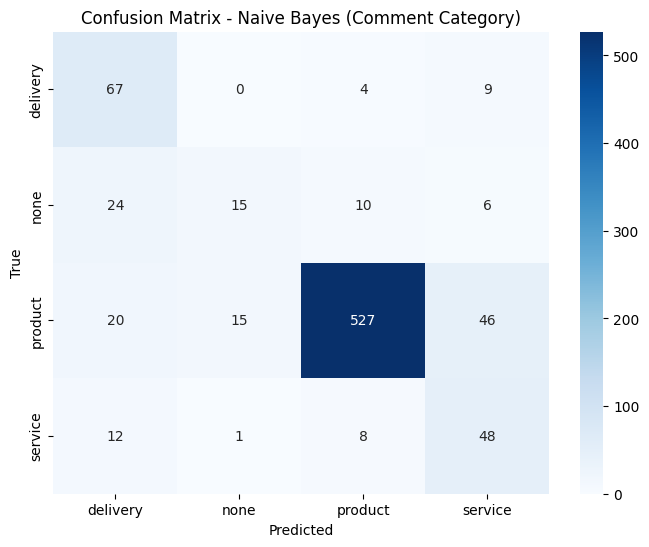

In [42]:
# Naive Bayes Model for commentCategoryName
nb_model_category = MultinomialNB()

# Lists to collect predictions and true labels
all_y_true_category = []
all_y_pred_category = []

# Cross-validation loop
for train_index, val_index in skf_category.split(X_vec_category, B):
    X_train_category, X_val_category = X_vec_category[train_index], X_vec_category[val_index]
    y_train_category, y_val_category = B.iloc[train_index], B.iloc[val_index]

    # SMOTE for handling class imbalance
    smote = SMOTE(random_state=42)
    X_train_res_category, y_train_res_category = smote.fit_resample(X_train_category, y_train_category)

    # Train Naive Bayes
    nb_model_category.fit(X_train_res_category, y_train_res_category)

    # Predict
    y_pred_category = nb_model_category.predict(X_val_category)

    # Append true labels and predictions
    all_y_true_category.extend(y_val_category)
    all_y_pred_category.extend(y_pred_category)

# After the loop, print classification report
print("Naive Bayes classification report for commentCategoryName:")
print(classification_report(all_y_true_category, all_y_pred_category))

# Generate confusion matrix
cm_category = confusion_matrix(all_y_true_category, all_y_pred_category)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_category, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_category.classes_, yticklabels=le_category.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Naive Bayes (Comment Category)')
plt.show()


XGBoost classification report for commentCategoryName:
              precision    recall  f1-score   support

           0       0.77      0.76      0.77        80
           1       0.47      0.69      0.56        55
           2       0.92      0.91      0.91       608
           3       0.55      0.39      0.46        69

    accuracy                           0.84       812
   macro avg       0.68      0.69      0.67       812
weighted avg       0.84      0.84      0.84       812



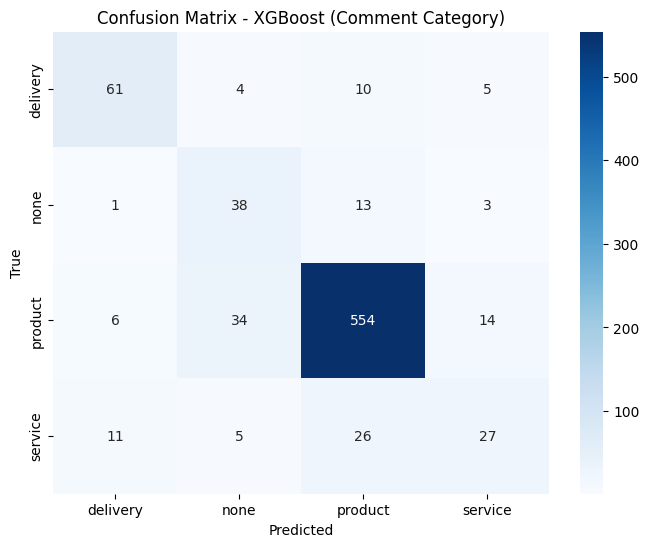

In [43]:
# XGBoost Model for commentCategoryName
xgb_model_category = XGBClassifier(eval_metric='mlogloss')

# Lists to collect predictions and true labels
all_y_true_category = []
all_y_pred_category = []

# Cross-validation loop
for train_index, val_index in skf_category.split(X_vec_category, B):
    X_train_category, X_val_category = X_vec_category[train_index], X_vec_category[val_index]
    y_train_category, y_val_category = B.iloc[train_index], B.iloc[val_index]

    # SMOTE for handling class imbalance
    smote = SMOTE(random_state=42)
    X_train_res_category, y_train_res_category = smote.fit_resample(X_train_category, y_train_category)

    # Train XGBoost
    xgb_model_category.fit(X_train_res_category, y_train_res_category)

    # Predict
    y_pred_category = xgb_model_category.predict(X_val_category)

    # Append true labels and predictions
    all_y_true_category.extend(y_val_category)
    all_y_pred_category.extend(y_pred_category)

# After the loop, print classification report
print("XGBoost classification report for commentCategoryName:")
print(classification_report(all_y_true_category, all_y_pred_category))

# Generate confusion matrix
cm_category = confusion_matrix(all_y_true_category, all_y_pred_category)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_category, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_category.classes_, yticklabels=le_category.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - XGBoost (Comment Category)')
plt.show()


In [44]:
import joblib

joblib.dump(cvec, 'cvec.pkl')
joblib.dump(le, 'le_sentiment.pkl')
joblib.dump(xgb_model, 'xgb_sentiment.pkl')

joblib.dump(le_category, 'le_category.pkl')
joblib.dump(xgb_model_category, 'xgb_category.pkl')

['xgb_category.pkl']

In [45]:
xgb_model.save_model('xgb_sentiment.json')
xgb_model_category.save_model('xgb_category.json')